### Gradient Boosting pour sales margin (colonne non éclatée) Gradient Boosting 

# %% Importation des bibliothèques nécessaires

In [89]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from lightgbm import LGBMRegressor
import numpy as np
import matplotlib.pyplot as plt

# %% Charger les données

In [90]:
chemin = "C:/Users/zineb/OneDrive/Bureau/hetic/DA/silver/data_clean.csv"
df = pd.read_csv(chemin)

# Enrichissement des données avec des caractéristiques temporelles
df['engage_at'] = pd.to_datetime(df['engage_at'], errors='coerce')
df['close_at'] = pd.to_datetime(df['close_at'], errors='coerce')

C:\Users\zineb\AppData\Local\Temp\ipykernel_11556\992984121.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['engage_at'] = pd.to_datetime(df['engage_at'], errors='coerce')
C:\Users\zineb\AppData\Local\Temp\ipykernel_11556\992984121.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['close_at'] = pd.to_datetime(df['close_at'], errors='coerce')


In [91]:
df.columns

Index(['opportunity_id', 'sales_agent', 'product', 'account', 'deal_stage',
       'engage_at', 'close_at', 'close_value', 'sector', 'series',
       'sales_price', 'manager', 'office_location', 'regional_office',
       'year_founded_at', 'revenue', 'number_of_employees'],
      dtype='object')

# %% Préparation des données

In [92]:

# Conversion des colonnes numériques et des dates
df['revenue'] = pd.to_numeric(df['revenue'].str.replace(',', '.', regex=True), errors='coerce')
df['engage_at'] = pd.to_datetime(df['engage_at'], errors='coerce')
df['close_at'] = pd.to_datetime(df['close_at'], errors='coerce')


# Remplir les valeurs de close_value avec 0 pour les états engaging, prospecting, et lost
df.loc[df['deal_stage'].isin(['engaging', 'prospecting', 'lost']), 'close_value'] = 0


# Calcul des colonnes dérivées
df['sales_margin'] = df.apply(
    lambda row: 0 if row['close_value'] == 0 else row['close_value'] - row['sales_price'], axis=1
)
df['sales_cycle_days'] = (df['close_at'] - df['engage_at']).dt.days.fillna(0)

# Extraction des informations temporelles
df['engage_month'] = df['engage_at'].dt.month
df['engage_day'] = df['engage_at'].dt.day
df['engage_weekday'] = df['engage_at'].dt.weekday

# Gestion des valeurs manquantes
df.fillna({'sales_margin': 0, 'close_value': 0}, inplace=True)


# Suppression des colonnes non pertinentes
columns_to_drop = [
    'opportunity_id',  'deal_stage',
       'engage_at', 'close_at', 'close_value', 
       'year_founded_at', 'sales_cycle_days'
]
df = df.drop(columns=columns_to_drop)

# %% Encodage des colonnes catégoriques

In [ ]:

label_encoders = {}
cat_columns = ['sales_agent', 'product', 'account', 'sector', 'series', 'manager', 'office_location', 'regional_office']

for col in cat_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le



In [94]:
df.columns

Index(['sales_agent', 'product', 'account', 'sector', 'series', 'sales_price',
       'manager', 'office_location', 'regional_office', 'revenue',
       'number_of_employees', 'sales_margin', 'engage_month', 'engage_day',
       'engage_weekday'],
      dtype='object')

# %% Séparation des caractéristiques (features) et de la cible

In [95]:

X = df.drop(columns=['sales_margin'])
y = df['sales_margin']

# Normalisation des colonnes numériques
numerical_cols = ['sales_price', 'revenue', 'number_of_employees', 'engage_month', 'engage_day', 'engage_weekday']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



# %% Division des données en ensembles d'entraînement et de test

In [96]:

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)




# %% Modélisation avec Gradient Boosting

In [97]:

model = LGBMRegressor(random_state=42, n_estimators=500, learning_rate=0.05, max_depth=7)
model.fit(X_train, y_train)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 403
[LightGBM] [Info] Number of data points in the train set: 5900, number of used features: 14
[LightGBM] [Info] Start training from score -3.730678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LGBMRegressor(learning_rate=0.05, max_depth=7, n_estimators=500,
              random_state=42)

# %% Évaluation du modèle

In [98]:

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.4f}")



Mean Absolute Error (MAE): 132.24
Mean Squared Error (MSE): 66764.44
R² Score: -0.1552


# %% Importance des caractéristiques

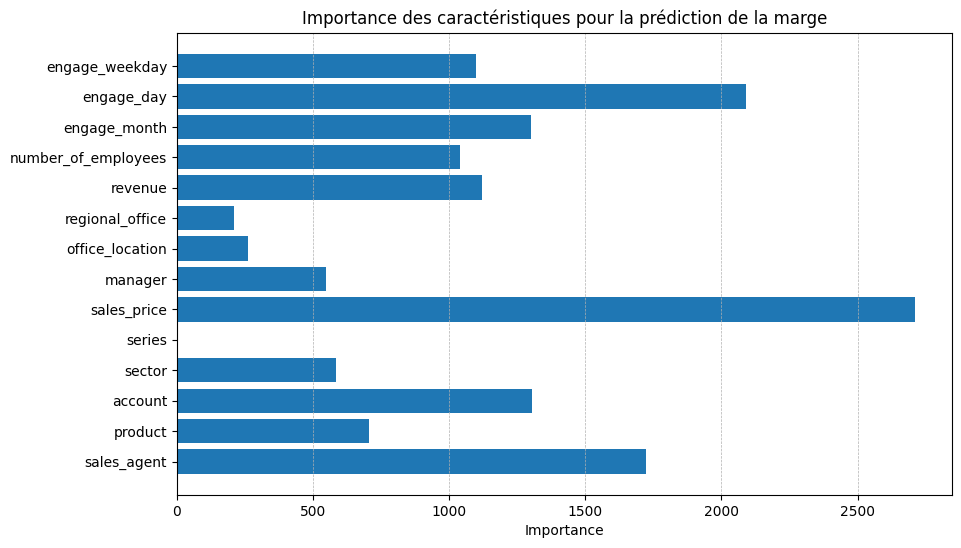

In [99]:

importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel("Importance")
plt.title("Importance des caractéristiques pour la prédiction de la marge")
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.show()



# %% Prédictions pour de nouvelles données simulées

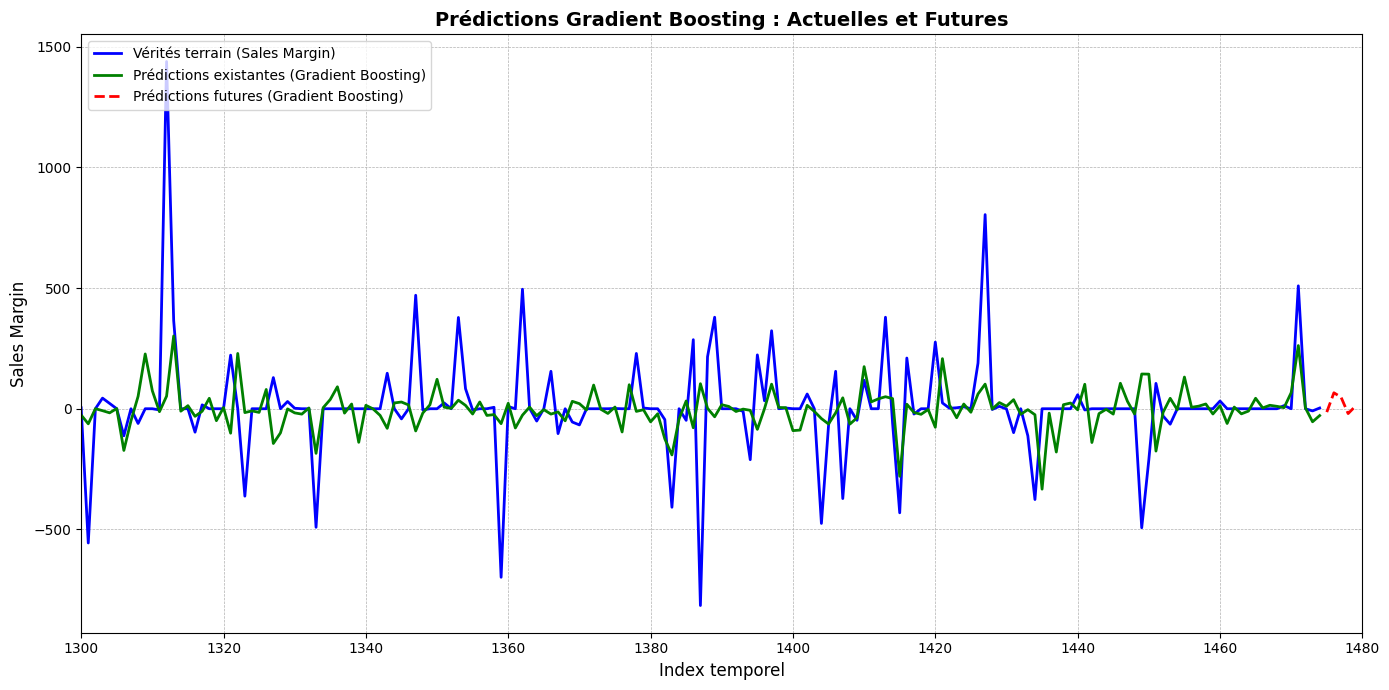

In [101]:

future_data_gb = pd.DataFrame({
    'sales_agent': [19, 3, 12, 3, 5],
    'product': [1, 1, 1, 1, 1],
    'account': [22, 30, 13, 6, 42],
    'sector': [7, 8, 3, 2, 5],
    'series': [3, 2, 1, 1, 1],
    'sales_price': [300, 100, 200, 500, 400],
    'manager': [5, 1, 2, 3, 1],
    'office_location': [14, 14, 3, 1, 12],
    'regional_office': [2, 2, 2, 2, 2],
    'revenue': [7708.38, 7708.38, 7708.38, 7708.38, 7708.38],
    'number_of_employees': [1000, 20000, 1300, 5000, 3000],
    'engage_month': [8.0, 11.0, 9.0, 7.0, 10.0],
    'engage_day': [24.0, 15.0, 30.0, 8.0, 13.0],
    'engage_weekday': [3.0, 6.0, 9.0, 1.0, 2.0]
})

# Normalisation des données futures
future_data_scaled = scaler.transform(future_data_gb)
future_predictions_gb = model.predict(future_data_scaled)

# Tracer les résultats
start_index = 1300  # Définir un point de départ pour l'affichage

plt.figure(figsize=(14, 7))

# Afficher les vraies valeurs des sales_margin pour le test
plt.plot(
    range(start_index, len(y_test)), 
    y_test[start_index:], 
    label="Vérités terrain (Sales Margin)", 
    color="blue", 
    linewidth=2
)

# Afficher les prédictions existantes (Gradient Boosting)
plt.plot(
    range(start_index, len(y_test)), 
    y_pred[start_index:], 
    label="Prédictions existantes (Gradient Boosting)", 
    color="green", 
    linestyle='-', 
    linewidth=2
)

# Afficher les prédictions pour les nouvelles données simulées
plt.plot(
    range(len(y_test), len(y_test) + len(future_predictions_gb)), 
    future_predictions_gb, 
    label="Prédictions futures (Gradient Boosting)", 
    color="red", 
    linestyle='--', 
    linewidth=2
)

# Limiter l'axe X à partir de l'index défini
plt.xlim(start_index, len(y_test) + len(future_predictions_gb))

# Ajouter des détails et améliorer la lisibilité
plt.xlabel("Index temporel", fontsize=12)
plt.ylabel("Sales Margin", fontsize=12)
plt.title("Prédictions Gradient Boosting : Actuelles et Futures", fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc="upper left")
plt.grid(which='major', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Afficher le graphique
plt.show()
